In [56]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Load and preprocess data

In [57]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [58]:
df = pd.read_csv('UPCOMI.csv')
df=convert_raw_data(df)
df1=df.reset_index()['Open']

In [59]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [60]:
# 4. Chia train test
ratio = 0.9
train_size = int(ratio * len(df1))
test_size = int((1-ratio) * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [61]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matri
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [62]:

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [63]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Define GRU Model

In [64]:
# 8. 

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [65]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


48/48 [==============================] - 4s 37ms/step - loss: 0.0115 - val_loss: 1.8222e-04
Epoch 2/100
48/48 [==============================] - 1s 28ms/step - loss: 3.3769e-04 - val_loss: 1.2301e-04
Epoch 3/100
48/48 [==============================] - 1s 28ms/step - loss: 2.3755e-04 - val_loss: 1.1595e-04
Epoch 4/100
48/48 [==============================] - 1s 31ms/step - loss: 2.0981e-04 - val_loss: 1.0988e-04
Epoch 5/100
48/48 [==============================] - 1s 31ms/step - loss: 1.9133e-04 - val_loss: 1.0505e-04
Epoch 6/100
48/48 [==============================] - 1s 27ms/step - loss: 1.7567e-04 - val_loss: 1.0306e-04
Epoch 7/100
48/48 [==============================] - 1s 29ms/step - loss: 1.6754e-04 - val_loss: 9.4395e-05
Epoch 8/100
48/48 [==============================] - 1s 30ms/step - loss: 1.5349e-04 - val_loss: 8.2772e-05
Epoch 9/100
48/48 [==============================] - 1s 27ms/step - loss: 1.4345e-04 - val_loss: 9.5450e-05
Epoch 10/100
48/48 [========================

In [66]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 8ms/step


In [67]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [69]:
mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 82.7369718071204
MSE: 6886.8115113330805
RMSE: 82.98681528612289
MAPE: 150.13806806547248


In [70]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1] -1
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.48947098 0.48751926 0.48330765 0.49809964 0.48587571 0.48782743
 0.49029276 0.48515665 0.48135593 0.46769389 0.44632768 0.44663585
 0.4459168  0.41088855 0.40914227 0.39044684 0.35418593 0.37524397
 0.38777607 0.39424756 0.39897278 0.40688238 0.39917822 0.39763739
 0.40698511 0.42372881 0.42711864 0.43215203 0.43780175 0.4459168
 0.45649718 0.43441192 0.4278377  0.44016436 0.43965074 0.43862352
 0.44211608 0.44488957 0.44982024 0.44622496 0.44488957 0.43379558
 0.43040575 0.43174114 0.43369286 0.42023626 0.42907036 0.4278377
 0.4324602  0.44016436 0.44786852 0.45156651 0.45218285 0.45146379
 0.45125835 0.44869029 0.44756035 0.44581407 0.44530046 0.44612224
 0.4538264  0.46019517 0.46409861 0.47457627 0.47878788 0.48320493
 0.47385722 0.47334361 0.48012327 0.4844376  0.48022599 0.48936826
 0.49768875 0.49861325 0.49727786 0.5048793  0.52049307 0.52244479
 0.51504879 0.51402157 0.50734463 0.49974319 0.49912686 0.49244992
 0.48330765 0.48936826 0.4914227  0.4877247  0.48289

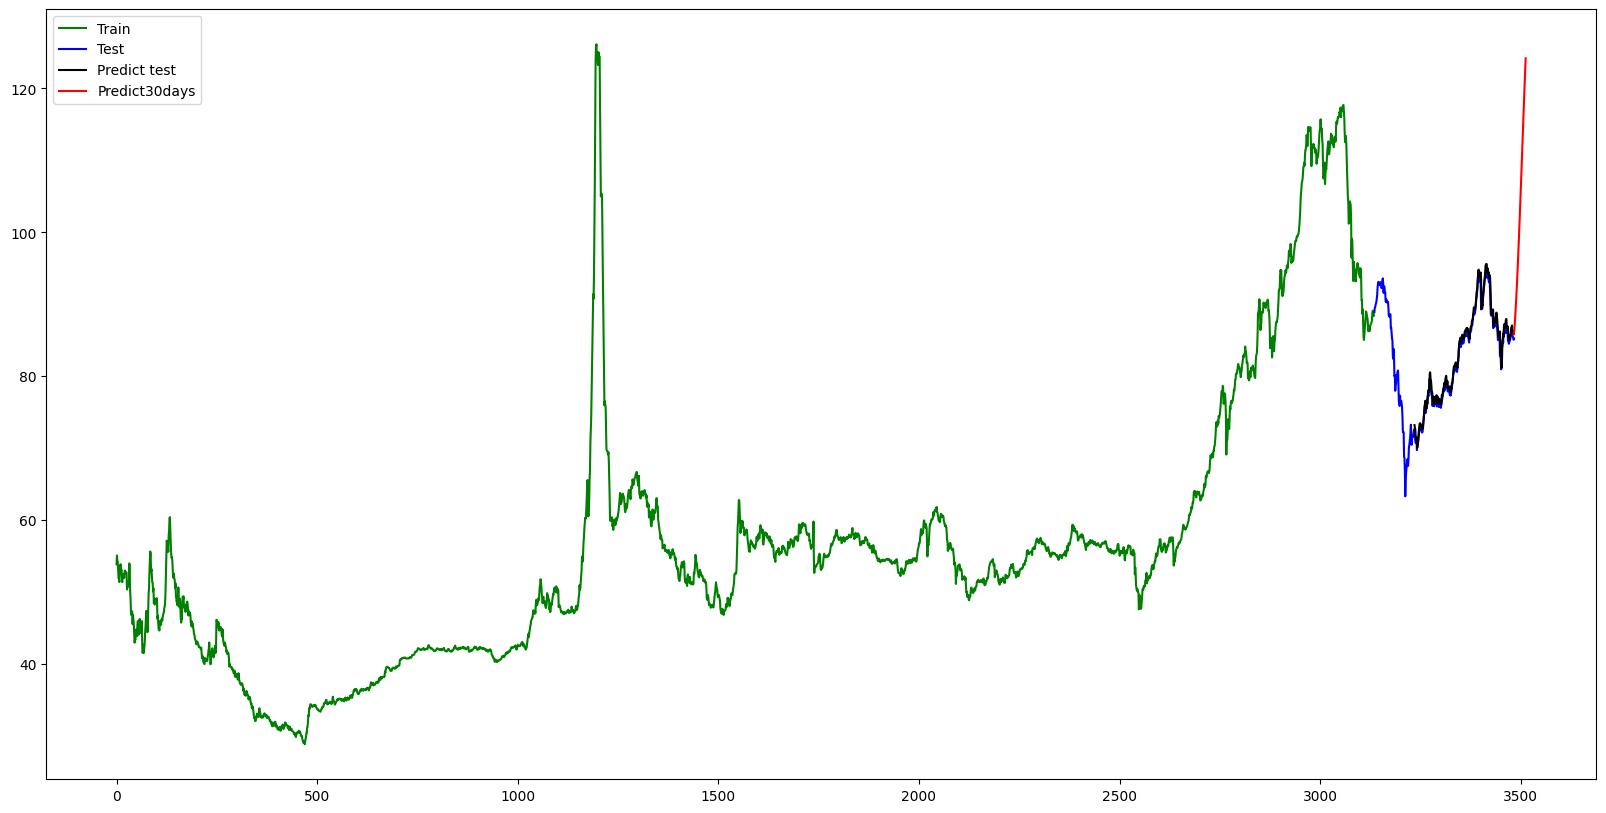

In [71]:
# 14.Vẽ hình
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data),color='green')
test_data_index = pd.RangeIndex(start=train_size, stop=len(df), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data),color='blue')
test_data_index = pd.RangeIndex(start=train_size+100, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred, color='black')
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output),color='red')
plt.legend(['Train','Test','Predict test','Predict30days'])
plt.show()